#### "Pandana" : calculer des métriques d'accessibilité aux aménités

##### Dans ce notebook je présente les principales fonctionnalités de la bibliothèque "Pandana", un package Python d'analyse de réseau qui utilise des hiérarchies de contraction pour calculer des métriques d'accessibilité de déplacement ultra-rapides et des chemins les plus courts.
##### Je développe plus particulièrement l'exemple d'accessibilité aux restaurants à 500 mètres dans le territoire de Naples en Italie

##### Sami Ramzi Chibane ©

In [1]:
import numpy as np
import pandas as pd

import pandana
print(pandana.__version__)

0.6.1


In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
from pandana.loaders import osm

import warnings
warnings.filterwarnings('ignore')

#### 1. Loading data

In [5]:
network = osm.pdna_network_from_bbox(37.698, -122.517, 37.819, -122.354)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.69800000,-122.51700000,37.81900000,-122.35400000);>;);out;'}"
Downloaded 27,858.7KB from www.overpass-api.de in 8.28 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 8.74 seconds
Returning OSM data with 156,653 nodes and 40,375 ways...
Edge node pairs completed. Took 25.23 seconds
Returning processed graph with 50,250 nodes and 74,785 edges...
Completed OSM data download and Pandana node and edge table creation in 35.85 seconds


In [6]:
network.nodes_df.head()

,x,y
id,,
33241803,-122.40,37.81
33242031,-122.42,37.80
54763573,-122.40,37.77
54891208,-122.39,37.77
54891395,-122.39,37.77


In [7]:
network.edges_df.head()

from          to  distance
33241803 2071244784  33241803  2071244784     20.08
         2071244838  33241803  2071244838     13.97
         9209919063  33241803  9209919063     12.52
33242031 65292112    33242031    65292112     71.49
         65292114    33242031    65292114     75.13

In [8]:
network.nodes_df.to_csv('nodes.csv')
network.edges_df.to_csv('edges.csv')

In [9]:
nodes = pd.read_csv('nodes.csv', index_col=0)
edges = pd.read_csv('edges.csv', index_col=[0,1])

In [10]:
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

#### 2. Shortest paths

##### Ici, je vais télécharger les points d'intérêts "restaurants" répertoriés sur Open Street Map (en utilisant la même extension OSMnet que ci-dessus), puis calculer quelques chemins les plus courts entre eux

In [11]:
restaurants = osm.node_query(
    37.698, -122.517, 37.819, -122.354, tags='"amenity"="restaurant"')

In [13]:
res = restaurants.sample(4)
res

,lat,lon,amenity,cuisine,name,wheelchair,addr:city,addr:housenumber,addr:postcode,addr:state,...,changing_table:location,brewery,leisure,strapline,noname,indoor_seating,short_name,contact:tripadvisor,was:contact:facebook,website:orders
id,,,,,,,,,,,,,,,,,,,,,
6704512686,37.79,-122.40,restaurant,NaN,Ladle & Leaf,NaN,NaN,221,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
826961058,37.79,-122.42,restaurant,mediterranean,Dunya,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9589058958,37.78,-122.42,restaurant,mexican,Taqueria El Castillo,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9401048617,37.79,-122.42,restaurant,chinese,Golden Horse Restaurant,NaN,San Francisco,1060,NaN,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Calculer le chemin le plus court entre eux en identifiant tout d'abord  le nœud le plus proche de chaque restaurant

In [14]:
nodes = network.get_node_ids(res.lon, res.lat).values
nodes

array([5020557545,   65307414, 8719605800, 7231525042], dtype=int64)

##### Ensuite, obtenez le routage entre le nœud en mètres

In [15]:
network.shortest_path(nodes[0], nodes[1])

array([5020557545,   65305817,   65352426,   65352429,   65347346,
       6955987016,   65326455,   65328705, 8719445204, 7233764920,
       7233764923, 9053837827, 9053837820, 9053837825, 7231068050,
       7231068051, 7231012166, 7231012174, 7231012165, 7231066382,
       7231066376, 7231066374, 7231066372, 7231085085, 7332987495,
       7332987499, 7231544185,   65295314, 7231525082,   65295320,
       6250503226,  850803353,  633686743,  633686735, 9183941602,
       9183941603,  850803362,   65307397,   65307399,   65298869,
         65307402,   65307404,   65307406, 7231544089,   65307408,
       7231544088,   65307412,   65307414], dtype=int64)

In [16]:
network.shortest_path_length(nodes[0], nodes[1])

1843.312

##### Calculer plusieurs chemins les plus courts à la fois

In [17]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat).values

In [18]:
origs = [o for o in restaurant_nodes for d in restaurant_nodes]
dests = [d for o in restaurant_nodes for d in restaurant_nodes]

In [19]:
%%time
distances = network.shortest_path_lengths(origs, dests)

Wall time: 29.1 s


##### Maintenant, nous avons la distance de chaque restaurant à l'autre restaurant

In [20]:
pd.Series(distances).describe()

count   2979076.00
mean      49304.63
std      435051.02
min           0.00
25%        2509.49
50%        4384.73
75%        6636.61
max     4294967.29
dtype: float64

#### 3. Proximité

##### Trouvez les restaurants les plus proches de chaque nœud. Pour effectuer un calcul à l'échelle du réseau comme celui-ci, nous devons d'abord ajouter formellement les restaurants au réseau

In [21]:
network.set_pois(category = 'restaurants',
                 maxdist = 1000,
                 maxitems = 3,
                 x_col = restaurants.lon, 
                 y_col = restaurants.lat)

##### Les paramètres maxdist et maxitems sont la distance maximale et le nombre d'éléments que vous prévoyez d'utiliser dans les recherches de proximité, afin que Pandana puisse optimiser la mise en cache. Nous pouvons maintenant exécuter la requête

results = network.nearest_pois(distance = 1000,
                               category = 'restaurants',
                               num_pois = 3,
                               include_poi_ids = True)
results.head()

In [22]:
results = network.nearest_pois(distance = 1000,
                               category = 'restaurants',
                               num_pois = 3,
                               include_poi_ids = True)
results.head()

,1,2,3,poi1,poi2,poi3
id,,,,,,
33241803,291.38,348.53,649.55,4077886989.00,1436065856.00,371250864.00
33242031,273.17,275.24,290.37,3609348594.00,1478520956.00,1478520961.00
54763573,282.32,377.73,436.98,1771741233.00,9057389584.00,9477190984.00
54891208,226.17,304.98,339.41,2453599646.00,2453600264.00,5512661856.00
54891395,266.57,345.38,391.63,2453599646.00,2453600264.00,6146447085.00


##### Ce sont les distances (en mètres) et les identifiants des trois restaurants les plus proches de chaque nœud du réseau

#### 4. Accessibilité

##### Nous allons maintenant répondre à la question suivante : combien de restaurants se trouvent à moins de 500 mètres de chaque nœud ?

##### "Pandana" appelle ce type de calcul une agrégation. Cela nécessite de transmettre une liste de nœuds de réseau et des valeurs associées.
##### Dans ce cas, la "valeur" correspond simplement à la présence d'un restaurant, mais il peut également s'agir de caractéristiques telles que la superficie en pieds carrés d'un immeuble ou le revenu d'un ménage...

In [23]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat)

In [24]:
network.set(restaurant_nodes, 
            name = 'restaurants')

In [25]:
accessibility = network.aggregate(distance = 500,
                                  type = 'count',
                                  name = 'restaurants')

In [26]:
accessibility.describe()

count   50250.00
mean       11.86
std        18.43
min         0.00
25%         0.00
50%         4.00
75%        16.00
max       147.00
dtype: float64

##### Notez que vous pouvez également calculer des moyennes, des sommes, des centiles et d'autres mesures, ainsi qu'appliquer une "décroissance" linéaire ou exponentielle à des valeurs plus éloignées.

#### 5. Visualisation

##### Pour visualiser le résultat, j'utilise "Matplotlib"

In [27]:
import matplotlib
from matplotlib import pyplot as plt

print(matplotlib.__version__)

3.5.0


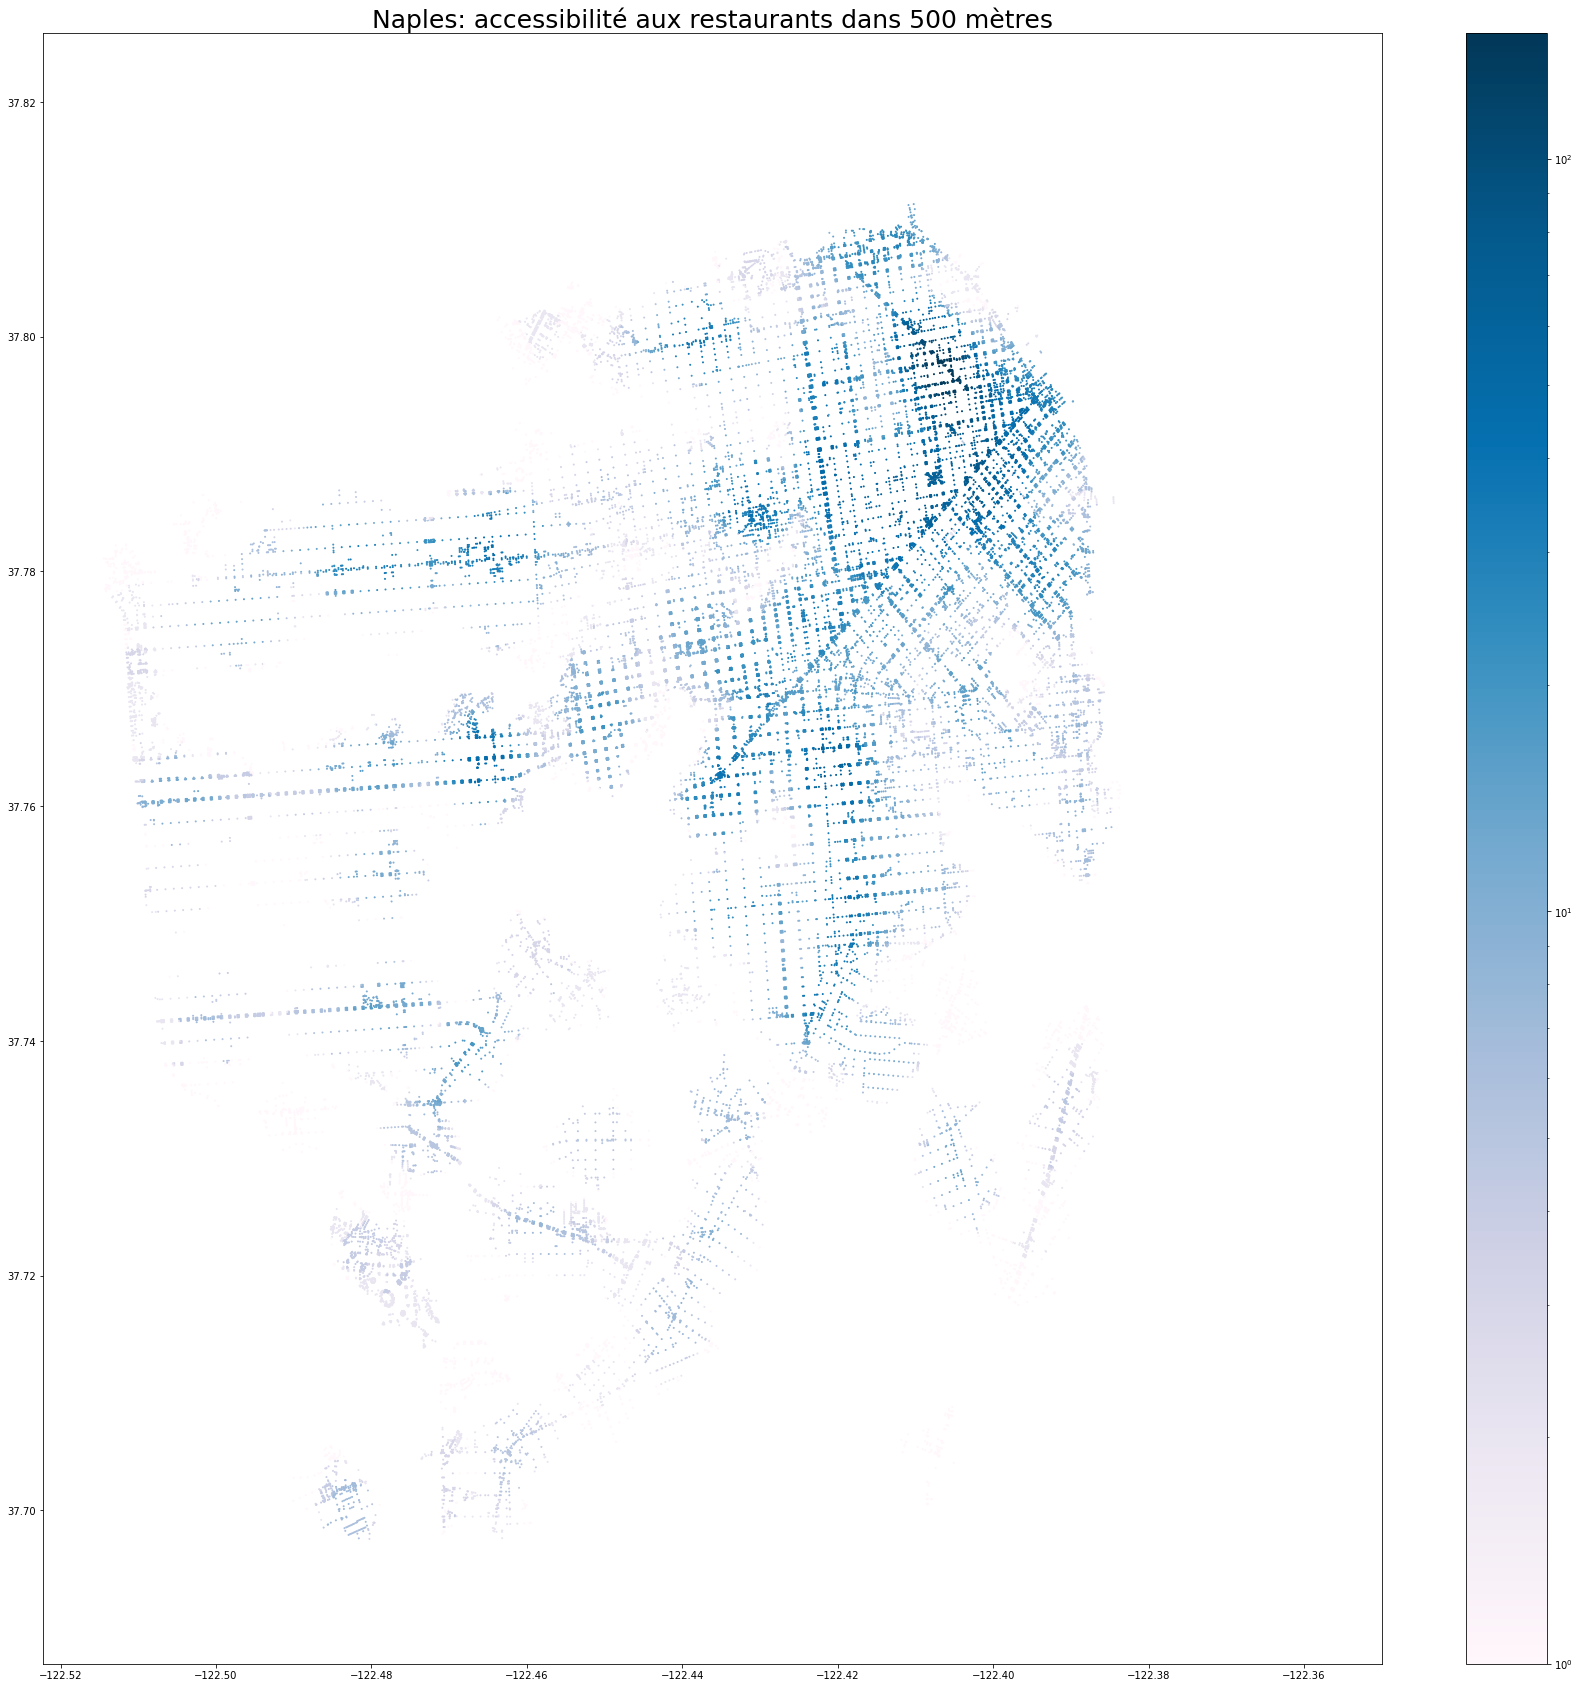

In [36]:
fig, ax = plt.subplots(figsize=(30,30))

plt.title('Naples: accessibilité aux restaurants dans 500 mètres', fontsize=25)
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='PuBu', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

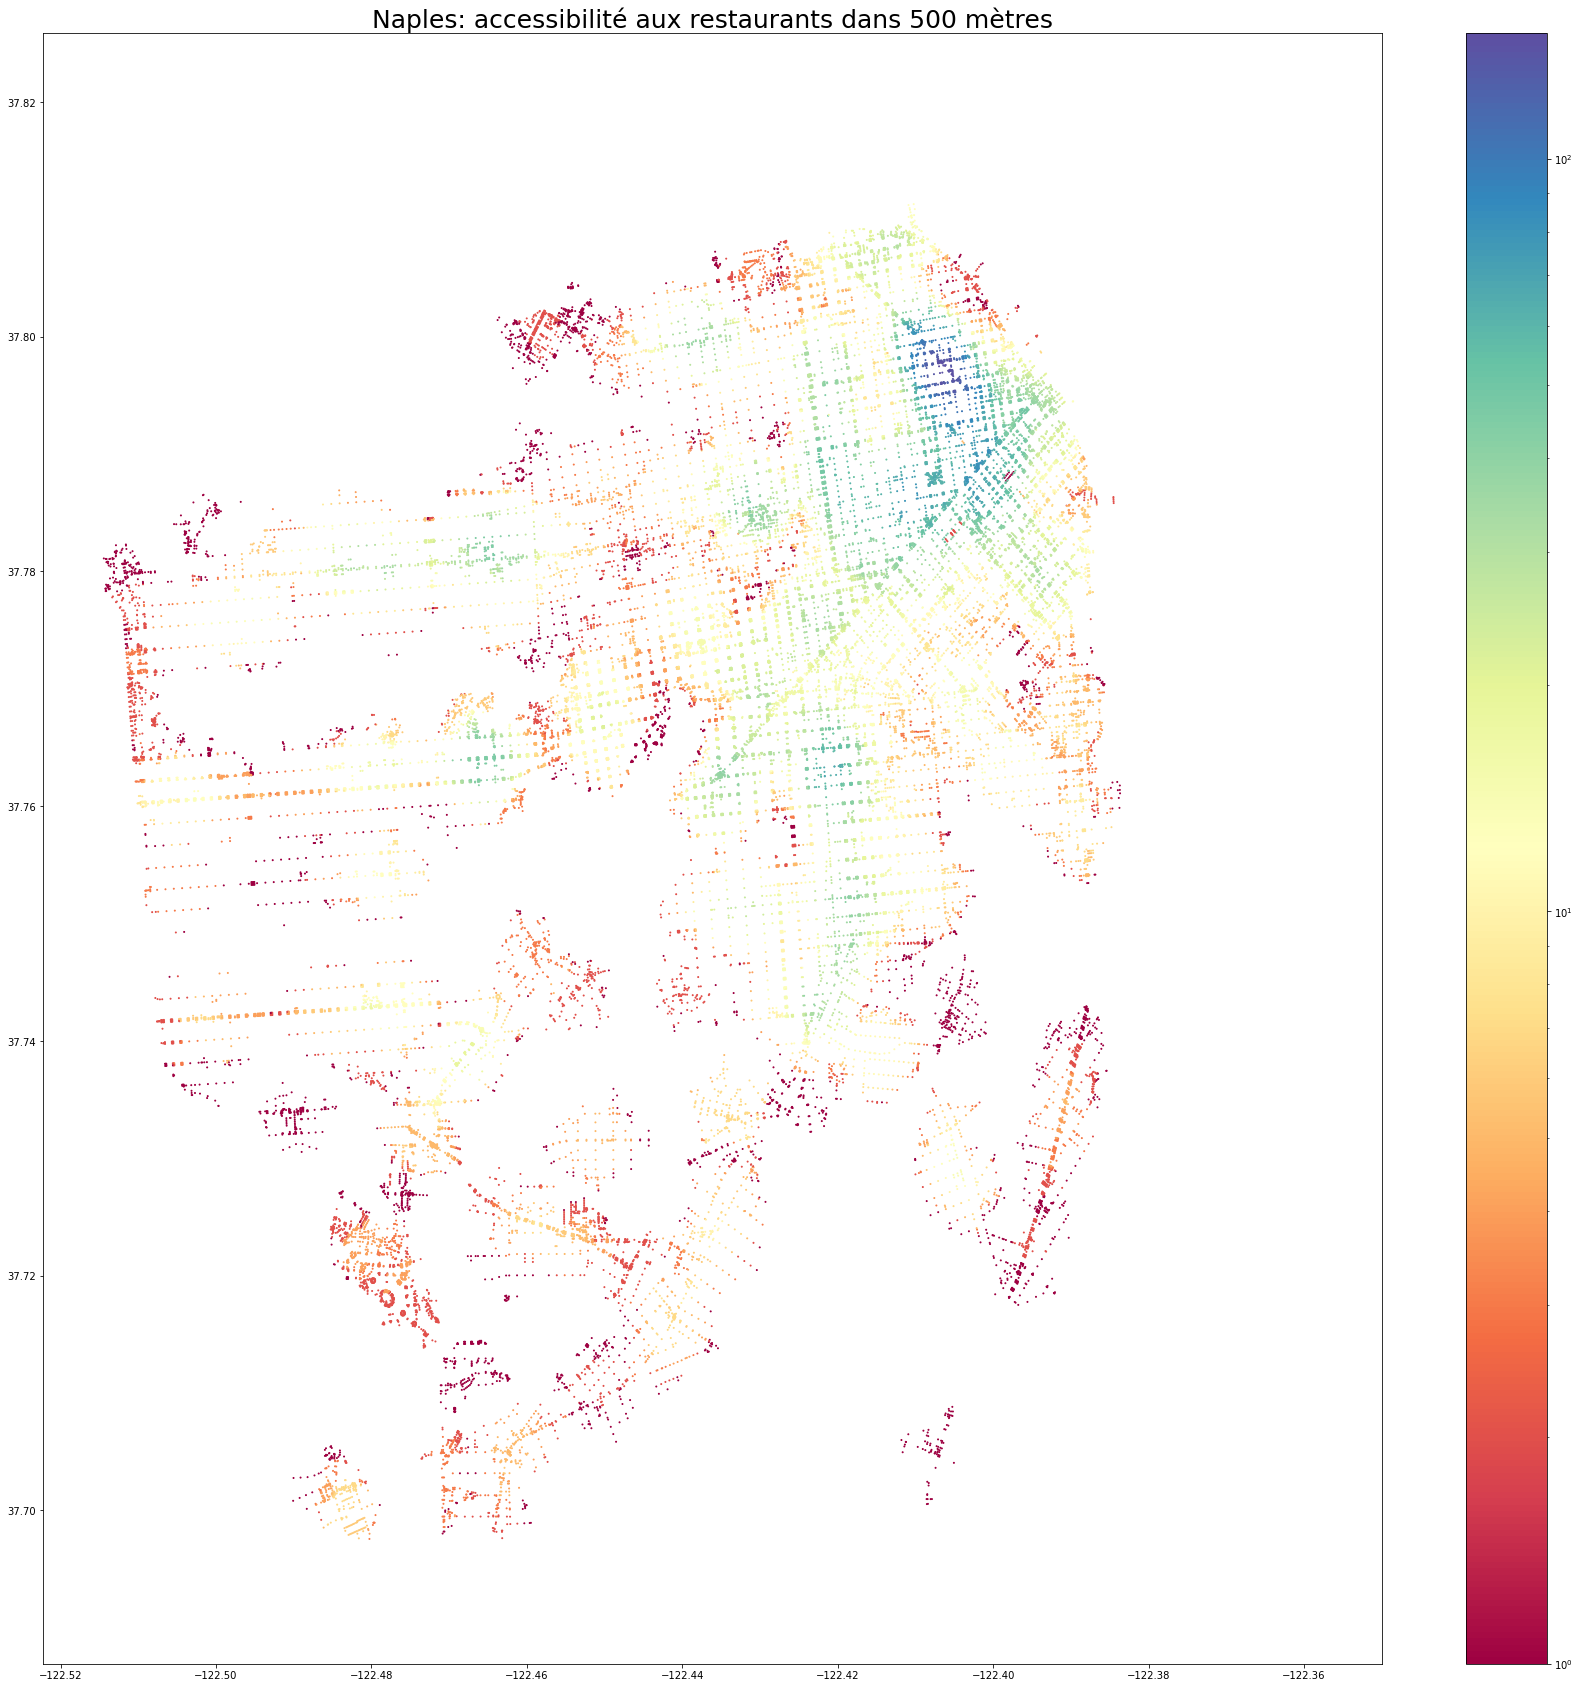

In [35]:
fig, ax = plt.subplots(figsize=(30,30))

plt.title('Naples: accessibilité aux restaurants dans 500 mètres', fontsize=25)
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='Spectral', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

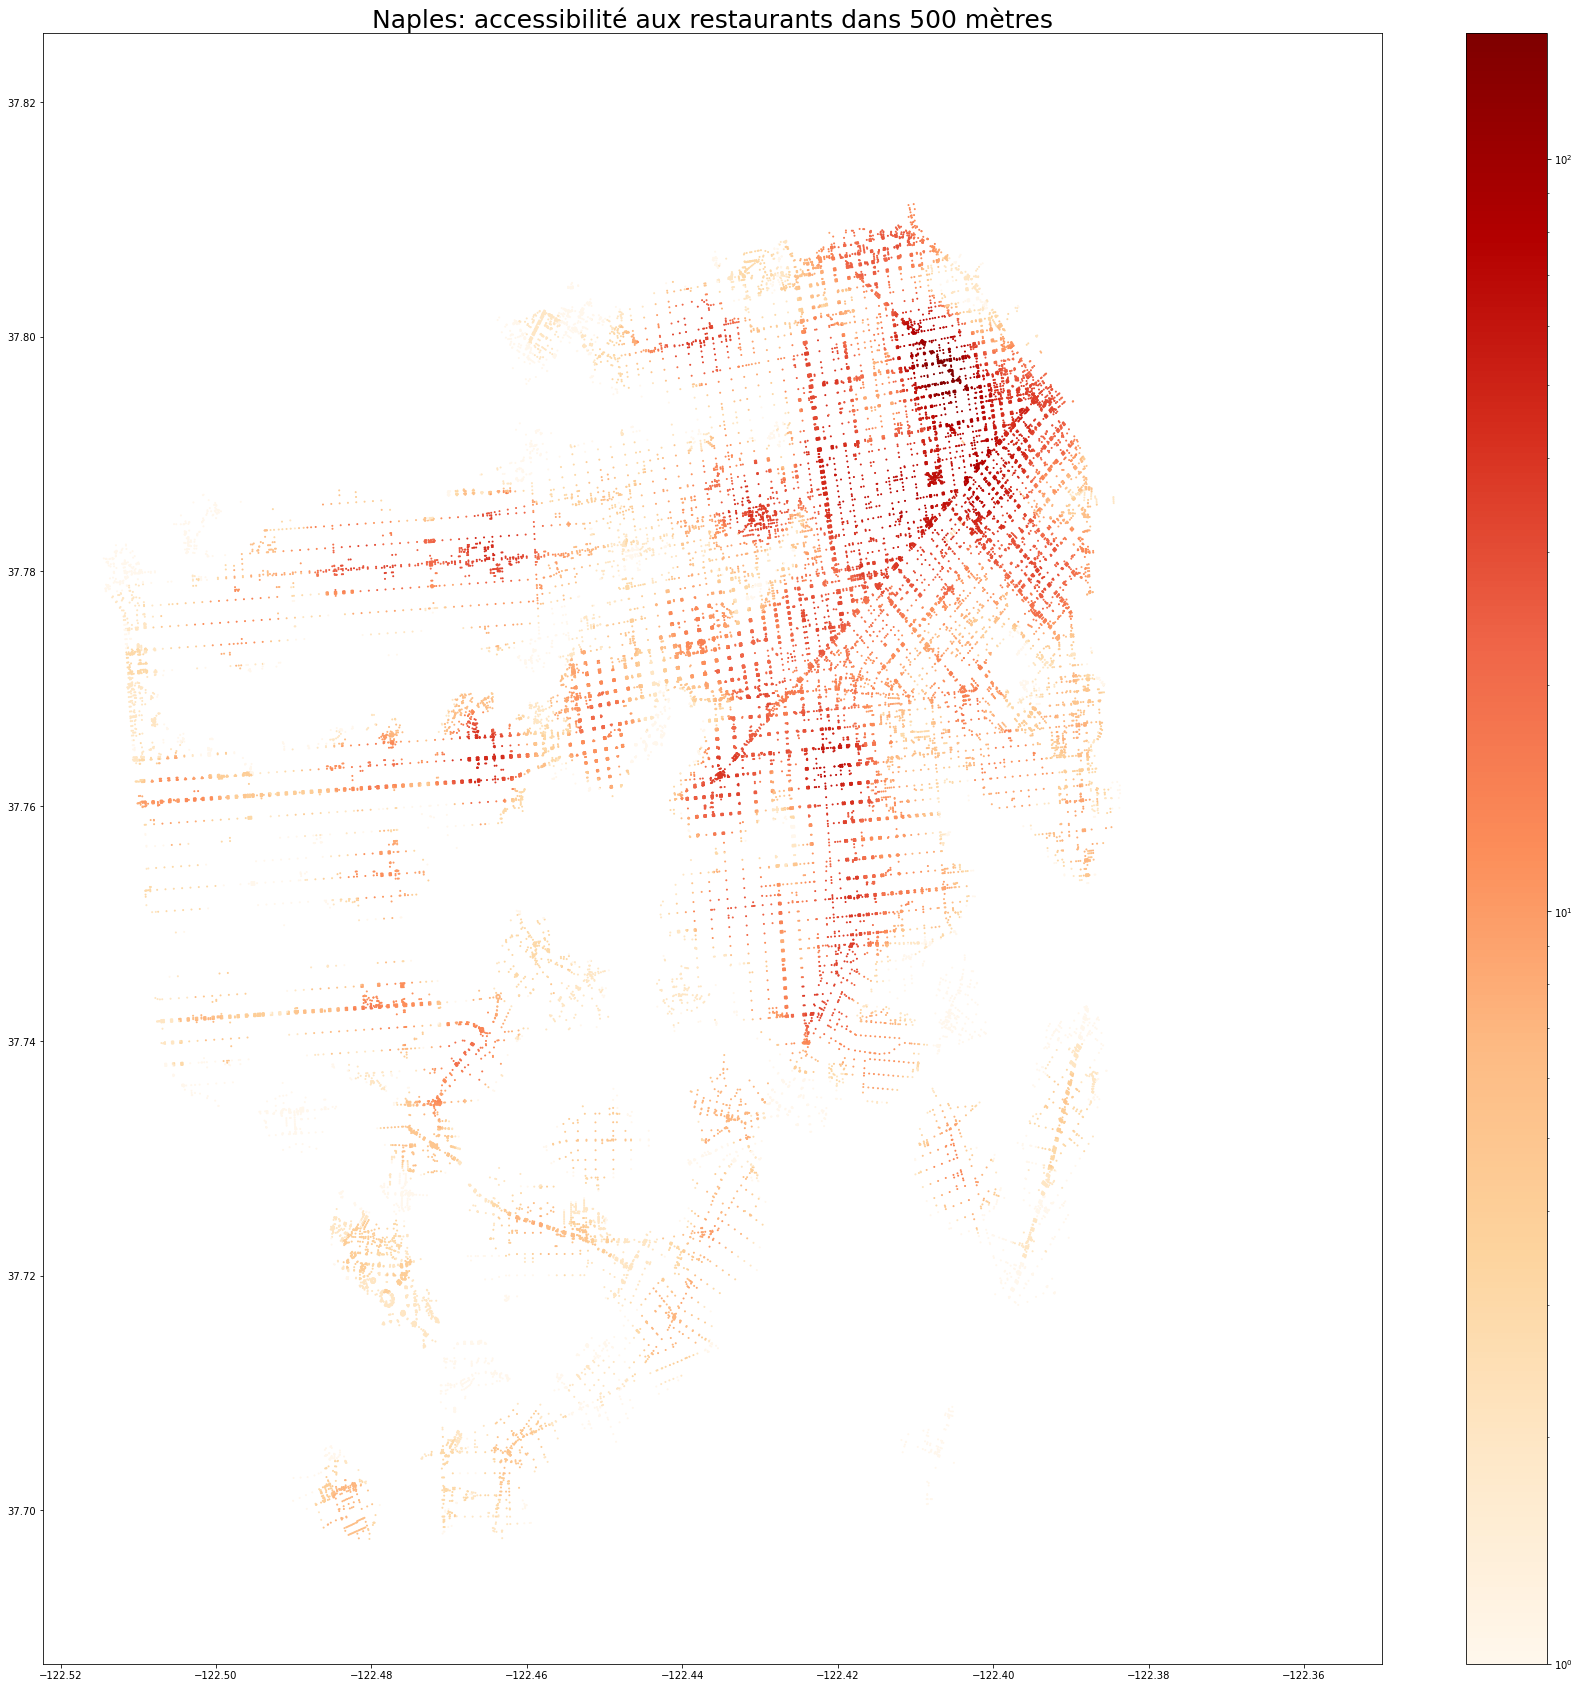

In [34]:
fig, ax = plt.subplots(figsize=(30,30))

plt.title('Naples: accessibilité aux restaurants dans 500 mètres', fontsize=25)
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='OrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()